# Text Classification

In my previous post, I covered some of the [basics of sentiment analysis](/sentiment-analysis-reddit-headlines-pythons-nltk/), where we gathered and categorize some data regarding Reddit’s political news headlines. Now, we can use that data to train our text classifier. 

So, in this article we will tackle some of the most common problems in machine learning while creating a text classifier in order to predict the sentiment of the headlines.

## How We're Using Classification

Classification is the problem of identifying the category of a new observation based of a training set of data containing observations whose category is known. In our case, our headlines are the observations and the categories are either positive or negative (based on the sentiment analysis on our previous article).

## Problem 1: Imbalanced Dataset

One of the most common problems, in machine learning, is working with an imbalanced dataset. Typically, an imbalanced dataset is a dataset where the classes are not represented equally. 

For example, you may have a binary classification problem with 100 examples. 90 of them belong to *Class 1* and 10 of them belong to *Class 2*.

After you train your model with your dataset, you start the evaluation process. At that point, you may experience accuracy up to 90%, which is commonly known as the [Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox). 

The reason behind the 90% accuracy is due to our model examining the data and deciding to always predict *Class 1*, resulting in high accuracy. So, to countermeasure this problem you can use any of the following techniques:

* **Collect more data:** If you can collect more data, then you should do it. This step might help balance the dataset and enhance the minor class examples.
* **Change you metric:** You can use either the Confusion Matrix, Precision, Recall or F1 score.
* **Synthetic data:** You can randomly sample the attributes from examples in the minority class to create more ‘fake’ data.
* **Resample data:** Add copies of minor class examples or delete examples from major class.
* **Penalized model:**  Implements an additional cost on the model for making classification mistakes on the minority class during training. These penalties bias the model towards the minority class.


In our dataset, we have <u>227 positive</u> examples and <u>307 negative</u> examples. So I will **resample the data** by deleting some negative examples, but feel free to use any of the other techniques.

Before getting to the good stuff, we just need to establish our imports:

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.classify.scikitlearn import SklearnClassifier

import math
import random
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (14,8)})

## Loading the Dataset

To load our dataset, we can do the following:

In [17]:
precision = 1

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

all_words_pos = []
line_counter = 0
with open("pos_news_titles.txt", "r", encoding='utf-8',
          errors='ignore') as f_pos:
    for line in f_pos.readlines():
        line_counter += 1
        words = tokenizer.tokenize(line)
        for w in words:
            if w.lower() not in stop_words:
                all_words_pos.append(w.lower())

all_words_neg = []
with open("neg_news_titles.txt", "r", encoding='utf-8',
          errors='ignore') as f_neg:
    for i, line in enumerate(f_neg):
        if i == line_counter:
            break
        words = tokenizer.tokenize(line)
        for w in words:
            if w.lower() not in stop_words:
                all_words_neg.append(w.lower())


The above code block is reading both the positive and negative files line by line, storing the words of each headline in a list, and using a counter to store the number of positive examples. The counter is to ensure we are only getting the same number of positive and negative examples.

Here's an example of what's contained in `all_words_pos` and `all_words_neg`:

In [18]:
print('Negative words:\n', all_words_neg[:10], '\n')
print('Positive words:\n', all_words_pos[:10])

Negative words:
 ['trump', 'conservative', 'leaders', 'plan', 'fails', 'blame', 'democrats', 'china', 'oks', '38'] 

Positive words:
 ['spicer', 'aarp', 'concerns', 'trying', 'accommodate', 'special', 'interests', 'nearly', 'everyone', 'agrees']


## Transform Words to Features

In order to train our classifier, we need to transform our words into examples. 

First, we will gather the $k$-most frequent words (you can experiment with $k$). After that, we will create a function that will search for these $k$ words in every headline, and mark their presence as 1 (True) and their absence as 0 (False).


In [19]:
all_words_total = nltk.FreqDist(all_words_pos + all_words_neg)
word_features = [x[0] for x in all_words_total.most_common(1000)]

print('Most common words:\n', all_words_total.most_common(10), '\n')
print('Word features:\n', word_features[:10])

Most common words:
 [('trump', 209), ('health', 68), ('care', 57), ('gop', 48), ('bill', 42), ('plan', 39), ('house', 32), ('obamacare', 32), ('donald', 30), ('new', 27)] 

Word features:
 ['trump', 'health', 'care', 'gop', 'bill', 'plan', 'house', 'obamacare', 'donald', 'new']


In [20]:
def feature_creation(words_list):
    features = {}
    for word in word_features:
        features[word] = word in words_list
    return features

## Begin Training

Now that we have our features and class labels, we are ready to start our training. 

### Text Classification with Naïve Bayes

For our first algorithm, we will choose the **Naïve Bayes Classifier**, which is one of the most common algorithms for text classification. We'll be using [NLTK's Naïve Bayes classifier](http://www.nltk.org/_modules/nltk/classify/naivebayes.html), but first we have to split our data into train and test sets (below).

If you train your model right now, with the usual 80% of the data as training set and the remaining 20% as the test set, the accuracy that you will get will not be quite ‘real’.  To get a better insight on our classifier’s generalization ability, there's two different techniques we can use:

1) **K-fold cross-validation**: The examples are randomly partitioned into $k$ equal sized subsets (usually 10). Out of the $k$ subsets, a single subsample is used for testing the model and the remaining $k-1$ subsets are used as training data. The cross-validation technique is then repeated $k$ times, resulting in process where each subset is used exactly once as part of the test set. Finally, the average of the $k$-runs is computed. The advantage of this method is that every example is used in both train and test set.

2) **Monte Carlo cross-validation**: Randomly splits the dataset into train and test data. The results are then averaged. The advantage of this method is that the proportion of the train/test split is not depending on the number of iterations. On the other hand, the disadvantage of this method is that some examples may never be selected in the test subset, whereas others may be selected more than once.

In our experiment, we will use a combination of both. We will randomly shuffle the examples beforehand and then we will implement the $k$-fold cross-validation.

### Turning Our Files into Features

First, we read the headlines one by one and create the features for each observation. For the feature creation, we are going to use our previously defined function `feature_creation()`, which is explained above. 

We could avoid reading the files twice, but doing it this way is better for simplicity and clarification:

In [21]:
feature_sets = []
with open("pos_news_titles.txt", "r", encoding='utf-8',
          errors='ignore') as f_pos:
    for headline in f_pos.readlines():
        tmp_list = []
        words = tokenizer.tokenize(headline)
        for w in words:
            if w.lower() not in stop_words:
                tmp_list.append(w.lower())
        feature_sets.append((feature_creation(tmp_list), 1))

with open("neg_news_titles.txt", "r", encoding='utf-8',
          errors='ignore') as f_neg:
    for i, headline in enumerate(f_neg):
        tmp_list = []
        if i == line_counter:
            break
        words = tokenizer.tokenize(headline)
        for w in words:
            if w.lower() not in stop_words:
                tmp_list.append(w.lower())
        feature_sets.append((feature_creation(tmp_list), -1))

### Cross-Validation

Now we will use the cross-validation technique. First, we separate the dataset into $10$ folds, then we use $9/10$ of these folds as a training sample and the remaining $1$ as a test sample. 

We'll repeat this process $10$ times in order to use every fold as test and as train. This technique allows us to have a better view on the generalization ability of our classifier.

In [22]:
random.shuffle(feature_sets)
bayes_runs = []
num_folds = 10
subset_size = math.ceil(len(feature_sets) / num_folds)

for i in range(num_folds):
    classifier_list = []
    training_set = (feature_sets[(i + 1) * subset_size:]
                    + feature_sets[:i * subset_size])
    testing_set = feature_sets[i * subset_size:(i + 1) * subset_size]

    classifier = nltk.NaiveBayesClassifier.train(training_set)
    classifier_list.append(classifier)
    bayes_runs.append((nltk.classify.accuracy(classifier, testing_set)) * 100)
    
    print("NaiveBayes Accuracy:", round(bayes_runs[-1], precision))

NaiveBayes Accuracy: 73.9
NaiveBayes Accuracy: 67.4
NaiveBayes Accuracy: 80.4
NaiveBayes Accuracy: 89.1
NaiveBayes Accuracy: 69.6
NaiveBayes Accuracy: 76.1
NaiveBayes Accuracy: 82.6
NaiveBayes Accuracy: 80.4
NaiveBayes Accuracy: 65.2
NaiveBayes Accuracy: 82.5


### Let's Plot our Naïve Bayes Results

To do the plotting in this article, we'll be using the [Seaborn](https://seaborn.pydata.org/) library. Sometimes I'll have some extra code just to make the plots look nicer, but they aren't necessary for initial data exploration. 

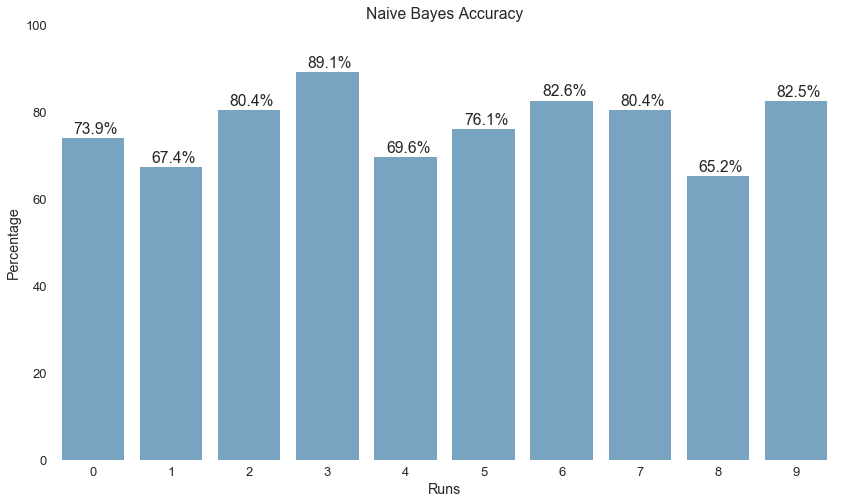

In [23]:
fig, ax = plt.subplots()

ax = sns.barplot(x=[i for i in range(len(bayes_runs))], y=bayes_runs, ci=None, color='#6CA6CD', zorder=1)

for p in ax.patches:
    percentage = str(round(p.get_height(), precision)) + '%'
    placement = (p.get_x() + 0.15, p.get_height() + 1)
    ax.annotate(percentage, placement)

ax.set(xlabel='Runs', ylabel='Percentage')
ax.set_title('Naive Bayes Accuracy')

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation
plt.ylim([0, 100])
plt.show()

Now we have a much more realistic percentage approach. 

### Text Classification Algorithms with scikit-learn

As you can see Naïve Bayes performed pretty well, so let’s experiment with other classifiers, shall we? The scikit-learn package is exactly what we need. Just import the classifiers you want and simply do the following procedure for every one:

In [24]:
runs = []
num_folds = 10
subset_size = math.ceil(len(feature_sets) / num_folds)
for i in range(num_folds):
    training_set = (feature_sets[(i + 1) * subset_size:] + feature_sets[:i * subset_size])
    testing_set = feature_sets[i * subset_size:(i + 1) * subset_size]

    classifier = nltk.NaiveBayesClassifier.train(training_set)
    runs.append((nltk.classify.accuracy(classifier, testing_set)) * 100)
    # print("NaiveBayes Accuracy:", round(runs[-1],precision))

    MNB_classifier = SklearnClassifier(MultinomialNB())
    MNB_classifier.train(training_set)
    runs.append((nltk.classify.accuracy(MNB_classifier, testing_set)) * 100)
    # print("MNB Accuracy:", round(runs[-1],precision))

    BernoulliNB_Classifier = SklearnClassifier(BernoulliNB())
    BernoulliNB_Classifier.train(training_set)
    runs.append((nltk.classify.accuracy(BernoulliNB_Classifier,
                 testing_set)) * 100)
    # print("BernoulliNB Accuracy:", round(runs[-1],precision))

    LogisticRegression_Classifier = SklearnClassifier(LogisticRegression())
    LogisticRegression_Classifier.train(training_set)
    runs.append((nltk.classify.accuracy(LogisticRegression_Classifier,
                 testing_set)) * 100)
    # print("LogisticRegression Accuracy:", round(runs[-1],precision))

    SGD_Classifier = SklearnClassifier(SGDClassifier())
    SGD_Classifier.train(training_set)
    runs.append((nltk.classify.accuracy(SGD_Classifier, testing_set)) * 100)
    # print("SGD Accuracy:", round(runs[-1],precision))

    LinearSVC_Classifier = SklearnClassifier(LinearSVC())
    LinearSVC_Classifier.train(training_set)
    runs.append((nltk.classify.accuracy(LinearSVC_Classifier,
                 testing_set)) * 100)
    # print("LinearSVC Accuracy:", round(runs[-1],precision))

    RFClassifier_Classifier = SklearnClassifier(RandomForestClassifier())
    RFClassifier_Classifier.train(training_set)
    runs.append(nltk.classify.accuracy(RFClassifier_Classifier,
                                       testing_set)*100)
    # print("RF Accuracy:", round(runs[-1],precision))

This huge block of code might seem confusing but bear with me. 

The above block simply executes the same process as previously shown with Naïve Bayes, only this time it uses 6 more classifying models. It also stores each run in a list, that we will use below to plot the average of each classifier. You can uncomment the print statements to see the individual percentage of each run.

### Plotting Model Results

The next code block first calculates the average for each of the seven classifiers, then using the seaborn library we produce a barchart (shown below). 

The plot shows the comparison between all seven classifier averages. The results are satisfying in general, with **accuracy over 70%**. The percentages between our classifiers don’t differ much and will vary from run to run. In our run.

*Stochastic Gradient Descent (SGD)* performed the best with **76.5%** while *Random Forest (RF)* performed the worst with **70.8%**. This small variance in our results indicates that we can achieve a decent accuracy, regardless of the model. 

If you are not satisfied with this result, you can always test more models individually or as a combination, which is what we will do next.

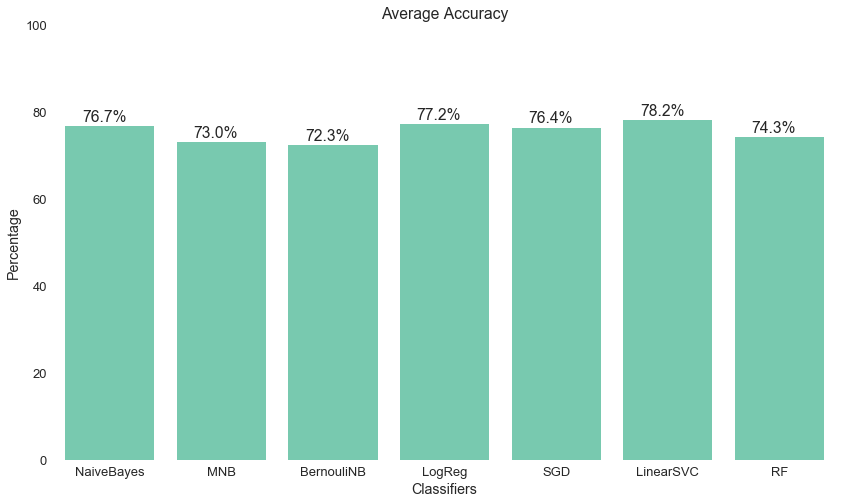

In [25]:
final = []
for e in range(7):
    average = [runs[i] for i in range(len(runs)) if i % 7 == e]
    final.append(round(sum(average) / len(average), precision))

data = pd.DataFrame({'classifiers': ["NaiveBayes", "MNB", "BernouliNB", "LogReg",
                    "SGD", "LinearSVC", "RF"], 'val': final })

fig, ax = plt.subplots()
ax = sns.barplot(x='classifiers', y='val', data=data, ci=None, color='#6bd6b4')

for p in ax.patches:
    percentage = str(round(p.get_height(), precision)) + '%'
    placement = (p.get_x() + 0.15, p.get_height() + 1)
    ax.annotate(percentage, placement)

ax.set(xlabel='Classifiers', ylabel='Percentage')
ax.set_title('Average Accuracy')

sns.despine(bottom=True, left=True)
plt.ylim([0, 100])
plt.show()

## Combining Classifiers

After we evaluated each classifier individually, it’s time to create a combinatory solution. It's quite common in Machine Learning to combine algorithms in order to achieve higher accuracy, but it doesn't always work.

In our case, we will use a simple majority rule where we will predict the headline’s category based on what the majority of classifiers predicts. 

For example, if 4 or more of our 7 classifiers predict negative, we will also predict negative.

The following `majority_votes()` function simply iterates over the list of classifiers and stores the individual predictions in a list. Then, it checks if the majority of prediction agrees with the correct answer (from our dataset), and increments our counter. Finally, it returns the accuracy percentage.

In [26]:
def majority_votes(classifiers, testing):
    correct = 0
    for example in testing:
        votes = []
        for c in classifiers:
            votes.append(c.classify(example[0]))
        if Counter(votes).most_common(1)[0][0] == example[1]:
            correct += 1

    return (correct / len(testing))*100

Next, we are going to do the exact same thing as the previous huge classifier block of code, only this time it stores the classifiers trained at each fold in order to combine them into a majority classifier:

In [27]:
combined_runs = []
num_folds = 10
subset_size = math.ceil(len(feature_sets) / num_folds)

for i in range(num_folds):
    classifier_list = []
    training_set = (feature_sets[(i + 1) * subset_size:] + feature_sets[:i * subset_size])
    testing_set = feature_sets[i * subset_size:(i + 1) * subset_size]

    classifier = nltk.NaiveBayesClassifier.train(training_set)
    classifier_list.append(classifier)

    MNB_classifier = SklearnClassifier(MultinomialNB())
    MNB_classifier.train(training_set)
    classifier_list.append(MNB_classifier)

    BernoulliNB_Classifier = SklearnClassifier(BernoulliNB())
    BernoulliNB_Classifier.train(training_set)
    classifier_list.append(BernoulliNB_Classifier)

    LogisticRegression_Classifier = SklearnClassifier(LogisticRegression())
    LogisticRegression_Classifier.train(training_set)
    classifier_list.append(LogisticRegression_Classifier)

    SGD_Classifier = SklearnClassifier(SGDClassifier())
    SGD_Classifier.train(training_set)
    classifier_list.append(SGD_Classifier)

    LinearSVC_Classifier = SklearnClassifier(LinearSVC())
    LinearSVC_Classifier.train(training_set)
    classifier_list.append(LinearSVC_Classifier)

    RFClassifier_Classifier = SklearnClassifier(RandomForestClassifier())
    RFClassifier_Classifier.train(training_set)
    classifier_list.append(RFClassifier_Classifier)
    
    combined_runs.append(majority_votes(classifier_list, testing_set))
    print("Majority Accuracy:", round(combined_runs[-1],1))

Majority Accuracy: 80.4
Majority Accuracy: 71.7
Majority Accuracy: 80.4
Majority Accuracy: 84.8
Majority Accuracy: 73.9
Majority Accuracy: 69.6
Majority Accuracy: 80.4
Majority Accuracy: 80.4
Majority Accuracy: 67.4
Majority Accuracy: 80.0


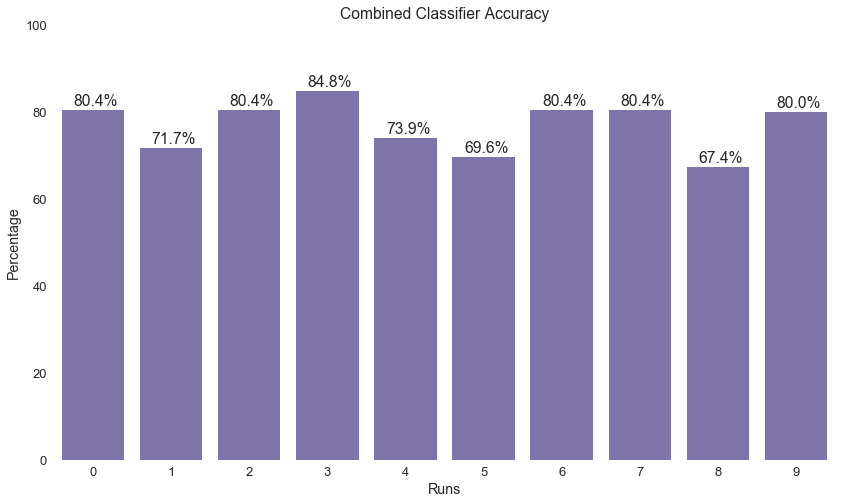

Average Majority Accuracy:  76.9


In [28]:
fig, ax = plt.subplots()
ax = sns.barplot(x=[i for i in range(len(combined_runs))], y=combined_runs, ci=None, color='#786BB2')

for p in ax.patches:
    percentage = str(round(p.get_height(), precision)) + '%'
    placement = (p.get_x() + 0.15, p.get_height() + 1)
    ax.annotate(percentage, placement)
    
ax.set(xlabel='Runs', ylabel='Percentage')
ax.set_title('Combined Classifier Accuracy')

sns.despine(bottom=True, left=True)
plt.ylim([0, 100])
plt.show()
print('Average Majority Accuracy: ', round(sum(combined_runs) / 10,precision))

And just to compare it to the original Naïve Bayes runs, let's do a quick Seaborn grouped bar chart:

In [29]:
num_runs = np.arange(len(bayes_runs))
col_names = ['classifier', 'run', 'percentage']

bayes_df = pd.DataFrame([['Naive Bayes', x, y] for x, y in zip(num_runs, bayes_runs)], columns=col_names)
combined_df = pd.DataFrame([['Combined', x, y] for x, y in zip(num_runs, combined_runs)], columns=col_names)

df = bayes_df.append(combined_df, ignore_index=True)
df

,classifier,run,percentage
0,Naive Bayes,0,73.913043
1,Naive Bayes,1,67.391304
2,Naive Bayes,2,80.434783
3,Naive Bayes,3,89.130435
4,Naive Bayes,4,69.565217
5,Naive Bayes,5,76.086957
6,Naive Bayes,6,82.608696
7,Naive Bayes,7,80.434783
8,Naive Bayes,8,65.217391
9,Naive Bayes,9,82.500000


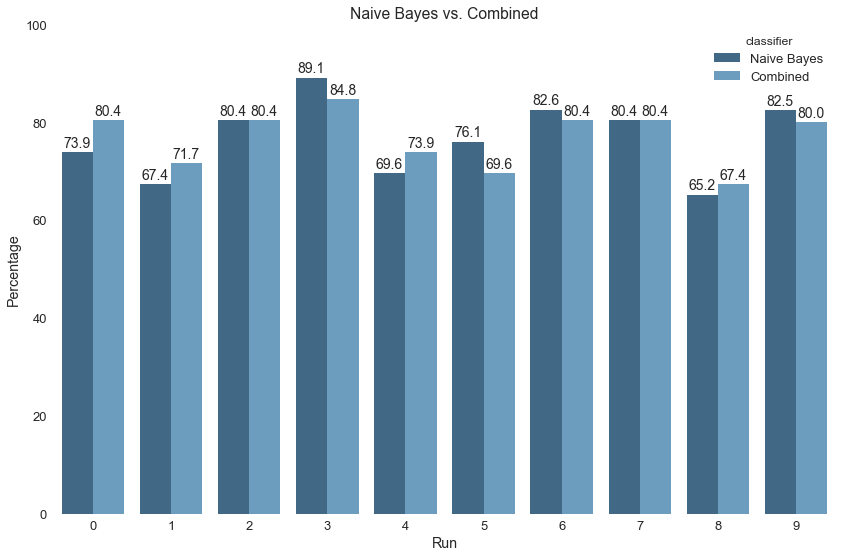

In [30]:
fig, ax = plt.subplots(figsize=(14,9))

ax = sns.barplot(x='run', y='percentage', hue='classifier', data=df, palette='Blues_d')
ax.set(xlabel='Run', ylabel='Percentage')

for p in ax.patches:
    percentage = str(round(p.get_height(), precision))
    placement = (p.get_x() + 0.02, p.get_height() + 1)
    ax.annotate(percentage, placement, size=14)

sns.despine(bottom=True, left=True)
plt.ylim([0, 100])
plt.title('Naive Bayes vs. Combined')
plt.show()

Although our majority classifier performed great, it didn't differ much from even the really straightforward Naïve Bayes aglorithm. Unfortunately, that's par for the course when exploring algorithms, and even though it might not have worked in our case, this strategy of combining algorithms will definitely come in handy for your future projects. 

To sum up what's been done up to this point: 
+ We've mined Reddit's political headlines via their API
+ Discovered the sentiment of those headlines using NLTK and the words in each headline
+ We split positive and negative headlines into two sets and used them as features for our classifiers
+ And finally, we discovered that our combined classification model can yeild up to an 82.6%, or 74.9% on average, chance of correctly predicting the sentiment of a political headline on Reddit.

If you have any questions or comments, please leave them below! Also, if you've done a similar project, or if these articles have helped you in your project, drop a link. I'd love to check it out.

Thanks for reading!